# Crimes in Chicago

by: Israel Diaz

email: idiazg@udd.cl

## Project Description

The main task is to answer a series of questions about trends in crimes in Chicago for a reporter for the local newspaper.

* Stakeholder Questions to Answer:
    1) Comparing Police Districts:
        * Which district has the most crimes? Which has the least?
    2) Crimes Across the Years:
        * Is the total number of crimes increasing or decreasing across the years?
        * Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?
    3) Comparing AM vs. PM Rush Hour:
        * Are crimes more common during AM rush hour or PM rush hour?
        * What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
        * Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?

## Data Description

**Chicago Crime Data**

* Source: [Chicago Data Portal:](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2) Crimes 2001 to Present
    * Data Description:
        * All Crimes that were reported in the city of Chicago and their details
        * [View Preview](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)
    * Includes:
        * type of crime, exact date/time, lat/long, District/ward, was there an arrest, etc.
    * Note: the .csv is very large and needs to be processed into smaller files to fit inside a GitHub repository. We have provided a helper notebook below to process your downloaded file into a repo-friendly format.

* Data Processing Helper Notebook:
    * It was used the helper [notebook](https://github.com/diazid/Chicago-Crime--Analysis/blob/main/Prep%20Chicago%20Crime%20Data.ipynb) in this repository to separate the data into smaller .csv files. The whole data may be found in the Chicago data Portal. 

## Project Deliverables

### 1. Load Libraries

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')

## Plotly for maps
import plotly.express as px
import plotly.graph_objects as go

## decomposition library
import statsmodels.tsa.api as tsa
from scipy.signal import find_peaks

## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

### 2. Load Data

In [2]:
## defining path variables
DATA_FOLDER = "data/Chicago/"


In [3]:
# get list of files from folder
crime_files = sorted(glob.glob(DATA_FOLDER+"*.csv"))
crime_files

['data/Chicago\\Chicago-Crime_2001.csv',
 'data/Chicago\\Chicago-Crime_2002.csv',
 'data/Chicago\\Chicago-Crime_2003.csv',
 'data/Chicago\\Chicago-Crime_2004.csv',
 'data/Chicago\\Chicago-Crime_2005.csv',
 'data/Chicago\\Chicago-Crime_2006.csv',
 'data/Chicago\\Chicago-Crime_2007.csv',
 'data/Chicago\\Chicago-Crime_2008.csv',
 'data/Chicago\\Chicago-Crime_2009.csv',
 'data/Chicago\\Chicago-Crime_2010.csv',
 'data/Chicago\\Chicago-Crime_2011.csv',
 'data/Chicago\\Chicago-Crime_2012.csv',
 'data/Chicago\\Chicago-Crime_2013.csv',
 'data/Chicago\\Chicago-Crime_2014.csv',
 'data/Chicago\\Chicago-Crime_2015.csv',
 'data/Chicago\\Chicago-Crime_2016.csv',
 'data/Chicago\\Chicago-Crime_2017.csv',
 'data/Chicago\\Chicago-Crime_2018.csv',
 'data/Chicago\\Chicago-Crime_2019.csv',
 'data/Chicago\\Chicago-Crime_2020.csv',
 'data/Chicago\\Chicago-Crime_2021.csv',
 'data/Chicago\\Chicago-Crime_2022.csv',
 'data/Chicago\\Chicago-Crime_2023.csv']

In [4]:
## Loadn data into a single dataframe
data = pd.concat([pd.read_csv(f) for f in crime_files])
data.head()

ID                    Date                Primary Type  \
0  3769790  01/01/2001 01:00:00 PM                       THEFT   
1  1310717  01/01/2001 01:00:00 AM             CRIMINAL DAMAGE   
2  1358218  01/01/2001 01:00:00 PM                     ASSAULT   
3  5462733  01/01/2001 01:00:00 AM  OFFENSE INVOLVING CHILDREN   
4  1309918  01/01/2001 01:00:00 AM                       THEFT   

                     Description Location Description  Arrest  Domestic  Beat  \
0        AGG: FINANCIAL ID THEFT            RESIDENCE   False     False   523   
1                     TO VEHICLE               STREET   False     False  2424   
2                         SIMPLE            APARTMENT   False     False   312   
3  AGG CRIM SEX ABUSE FAM MEMBER            RESIDENCE   False      True   233   
4                 $500 AND UNDER  TAVERN/LIQUOR STORE   False     False  1924   

   District  Ward   Latitude  Longitude  
0       5.0  34.0  41.673171 -87.638000  
1      24.0   NaN  42.012391 -87.678032  
2       3.0   NaN  41.778744 -87.612135  
3       2.0  20.0  41.789084 -87.620849  
4      19.0   NaN  41.940001 -87.654258

### 3. Data Preparation

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7763122 entries, 0 to 52377
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 666.3+ MB


#### Turing Date column into datetime

In [6]:
# format data
format='%m/%d/%Y %I:%M:%S %p'

## convert to datetime
data['Date'] = pd.to_datetime(data['Date'], format=format, errors='coerce')

In [7]:
data['Date']

0       2001-01-01 13:00:00
1       2001-01-01 01:00:00
2       2001-01-01 13:00:00
3       2001-01-01 01:00:00
4       2001-01-01 01:00:00
                ...        
52373   2023-03-22 12:52:00
52374   2023-03-22 12:53:00
52375   2023-03-22 12:55:00
52376   2023-03-22 12:59:00
52377   2023-03-22 00:59:00
Name: Date, Length: 7763122, dtype: datetime64[ns]

In [8]:
data['Date'].isna().sum()

0

No missing values in Date column, now I'll set the index to Date

In [9]:
## Set index to date
data = data.set_index('Date')
data.head()

ID                Primary Type  \
Date                                                       
2001-01-01 13:00:00  3769790                       THEFT   
2001-01-01 01:00:00  1310717             CRIMINAL DAMAGE   
2001-01-01 13:00:00  1358218                     ASSAULT   
2001-01-01 01:00:00  5462733  OFFENSE INVOLVING CHILDREN   
2001-01-01 01:00:00  1309918                       THEFT   

                                       Description Location Description  \
Date                                                                      
2001-01-01 13:00:00        AGG: FINANCIAL ID THEFT            RESIDENCE   
2001-01-01 01:00:00                     TO VEHICLE               STREET   
2001-01-01 13:00:00                         SIMPLE            APARTMENT   
2001-01-01 01:00:00  AGG CRIM SEX ABUSE FAM MEMBER            RESIDENCE   
2001-01-01 01:00:00                 $500 AND UNDER  TAVERN/LIQUOR STORE   

                     Arrest  Domestic  Beat  District  Ward   Latitude  \
Date                                                                     
2001-01-01 13:00:00   False     False   523       5.0  34.0  41.673171   
2001-01-01 01:00:00   False     False  2424      24.0   NaN  42.012391   
2001-01-01 13:00:00   False     False   312       3.0   NaN  41.778744   
2001-01-01 01:00:00   False      True   233       2.0  20.0  41.789084   
2001-01-01 01:00:00   False     False  1924      19.0   NaN  41.940001   

                     Longitude  
Date                            
2001-01-01 13:00:00 -87.638000  
2001-01-01 01:00:00 -87.678032  
2001-01-01 13:00:00 -87.612135  
2001-01-01 01:00:00 -87.620849  
2001-01-01 01:00:00 -87.654258

In [10]:
len(data)

7763122

#### Consistence of the data

In [11]:
## converted to a set because I wanted to see ordered.
set(data['Primary Type'].unique().tolist())

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIM SEXUAL ASSAULT',
 'CRIMINAL DAMAGE',
 'CRIMINAL SEXUAL ASSAULT',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'DOMESTIC VIOLENCE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'NON - CRIMINAL',
 'NON-CRIMINAL',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

We see a couple of in consistencies in `CRIM SEXUAL ASSAULT`, `CRIMINAL SEXUAL ASSAULT`, `NON - CRIMINAL`, `NON-CRIMINAL`, `NON-CRIMINAL (SUBJECT SPECIFIED)` that need to be fixed.

In [12]:
replace_type = {'CRIM SEXUAL ASSAULT' : 'CRIMINAL SEXUAL ASSAULT',
                'NON - CRIMINAL' : 'NON-CRIMINAL',
                'NON-CRIMINAL (SUBJECT SPECIFIED)' : 'NON-CRIMINAL'}

data['Primary Type'] = data['Primary Type'].replace(replace_type)

## checking if the changes were made
set(data['Primary Type'].unique().tolist())

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIMINAL DAMAGE',
 'CRIMINAL SEXUAL ASSAULT',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'DOMESTIC VIOLENCE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'NON-CRIMINAL',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

#### Ploting a sample into a map

As the original dataset is too large, I'll take a sample of 1% of the data to plot into a map using plotly, and year 2022

In [13]:
## the sample saves the proportion of each crime type
sample_df = data.groupby('Primary Type').apply(lambda x: x.sample(frac=0.01))

## taken from https://stackoverflow.com/questions/46026935/sample-rows-of-pandas-dataframe-in-proportion-to-counts-in-a-column#:~:text=You%20can%20use%20groupby%20and%20sample%20sample_df,%3D%20df.groupby%20%28%27group_id%27%29.apply%20%28lambda%20x%3A%20x.sample%20%28frac%3D0.1%29%29

In [14]:
sample_df.index = sample_df.index.droplevel(0)

In [15]:
sample_df.loc['2022', :]

ID       Primary Type  \
Date                                               
2022-08-14 21:25:00  12794249              ARSON   
2022-07-22 05:20:00  12768876              ARSON   
2022-12-06 01:48:00  12913702              ARSON   
2022-10-20 17:30:00  12865710            ASSAULT   
2022-08-02 03:00:00  12780643            ASSAULT   
...                       ...                ...   
2022-01-03 22:14:00  12584003  WEAPONS VIOLATION   
2022-07-27 22:17:00  12775002  WEAPONS VIOLATION   
2022-01-01 01:44:00  12581830  WEAPONS VIOLATION   
2022-09-13 09:16:00  12825680  WEAPONS VIOLATION   
2022-07-31 20:22:00  12779167  WEAPONS VIOLATION   

                                             Description  \
Date                                                       
2022-08-14 21:25:00                              BY FIRE   
2022-07-22 05:20:00                              BY FIRE   
2022-12-06 01:48:00                        ATTEMPT ARSON   
2022-10-20 17:30:00                               SIMPLE   
2022-08-02 03:00:00  AGGRAVATED - OTHER DANGEROUS WEAPON   
...                                                  ...   
2022-01-03 22:14:00        UNLAWFUL POSSESSION - HANDGUN   
2022-07-27 22:17:00        UNLAWFUL POSSESSION - HANDGUN   
2022-01-01 01:44:00        UNLAWFUL POSSESSION - HANDGUN   
2022-09-13 09:16:00           RECKLESS FIREARM DISCHARGE   
2022-07-31 20:22:00           RECKLESS FIREARM DISCHARGE   

                            Location Description  Arrest  Domestic  Beat  \
Date                                                                       
2022-08-14 21:25:00                       STREET   False      True  1114   
2022-07-22 05:20:00                       STREET   False     False   911   
2022-12-06 01:48:00                       STREET   False     False   833   
2022-10-20 17:30:00                       STREET   False     False   432   
2022-08-02 03:00:00  RESIDENCE - PORCH / HALLWAY   False     False   311   
...                                          ...     ...       ...   ...   
2022-01-03 22:14:00       VEHICLE NON-COMMERCIAL    True     False  1131   
2022-07-27 22:17:00                       STREET    True     False   512   
2022-01-01 01:44:00                       STREET    True     False  1133   
2022-09-13 09:16:00                       STREET   False     False  1133   
2022-07-31 20:22:00                       STREET   False     False  1511   

                     District  Ward   Latitude  Longitude  
Date                                                       
2022-08-14 21:25:00      11.0  28.0  41.886927 -87.731902  
2022-07-22 05:20:00       9.0  12.0  41.828238 -87.696319  
2022-12-06 01:48:00       8.0  13.0  41.767862 -87.713943  
2022-10-20 17:30:00       4.0  10.0  41.703827 -87.535283  
2022-08-02 03:00:00       3.0  20.0  41.783116 -87.615694  
...                       ...   ...        ...        ...  
2022-01-03 22:14:00      11.0  28.0  41.876073 -87.733906  
2022-07-27 22:17:00       5.0   9.0  41.702682 -87.618519  
2022-01-01 01:44:00      11.0  28.0  41.876232 -87.721351  
2022-09-13 09:16:00      11.0  24.0  41.873507 -87.720881  
2022-07-31 20:22:00      15.0  29.0  41.895608 -87.767853  

[2363 rows x 11 columns]

In [16]:
## Plotting the crimes into a map
fig = px.scatter_mapbox(sample_df.loc['2022', :], lat="Latitude", lon="Longitude", hover_name="Primary Type",
                        hover_data=["Primary Type", "Arrest"], color="Primary Type",
                        #zoom=3, height=300,
                        )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(autosize=False,
                  width=800,
                  height=500)
fig.show()
plt.gcf().savefig('img/Chicago_map.png')

<Figure size 1200x400 with 0 Axes>

The above plot shows the crimes that happened in 2022, and it's clear that the most crimes are concentrated in the downtown area.

Note: the plot is javascript based, and won't be shown in Github platform.

### 3.1) Comparing Police Districts:

* Which district has the most crimes? Which has the least?

Chicago has 22 police districts.

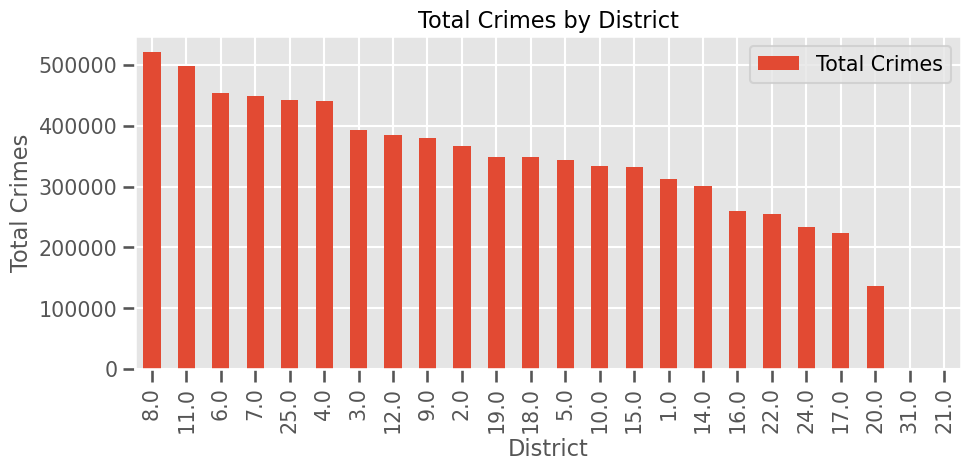

In [17]:
## Exploring districts
crime_counts = data['District'].value_counts().to_frame("Total Crimes")
fig, ax = plt.subplots(figsize=(10,5))
crime_counts.plot(kind='bar', figsize=(10,5), title='Total Crimes by District', ax=ax)
ax.set_xlabel('District')
ax.set_ylabel('Total Crimes')
fig.tight_layout()
plt.gcf().savefig('img/Chicago_crimes_by_district.png')

<strong>According to this data, the district with the most crimes is the 8TH with 521830 crimes, and the district with the least crimes is 21ST with 4 crimes.</strong>

###  3.2) Crimes Across the Years:
* Is the total number of crimes increasing or decreasing across the years?
* Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?

To address this question I'll group crimes by year, and resolve the count of observations for each crime type. I'll study observations until year 2022

In [18]:
## creating the year column
data['Year'] = data.index.year

In [19]:
## agregating data by year
yearly_crime_counts = data.groupby(by=['Year', 'Primary Type']).size().to_frame('Total Crimes').reset_index()
yearly_crime_counts = yearly_crime_counts[yearly_crime_counts['Year'] <= 2022]
yearly_crime_counts.sample(8, random_state = SEED)

Year            Primary Type  Total Crimes
379  2013       WEAPONS VIOLATION          3245
199  2007  PUBLIC PEACE VIOLATION          3315
30   2001       WEAPONS VIOLATION          4277
254  2009           OTHER OFFENSE         25601
321  2012                   ARSON           469
297  2011         CRIMINAL DAMAGE         37332
247  2009    LIQUOR LAW VIOLATION           746
469  2016             SEX OFFENSE          1043

#### Overall crimes across the years

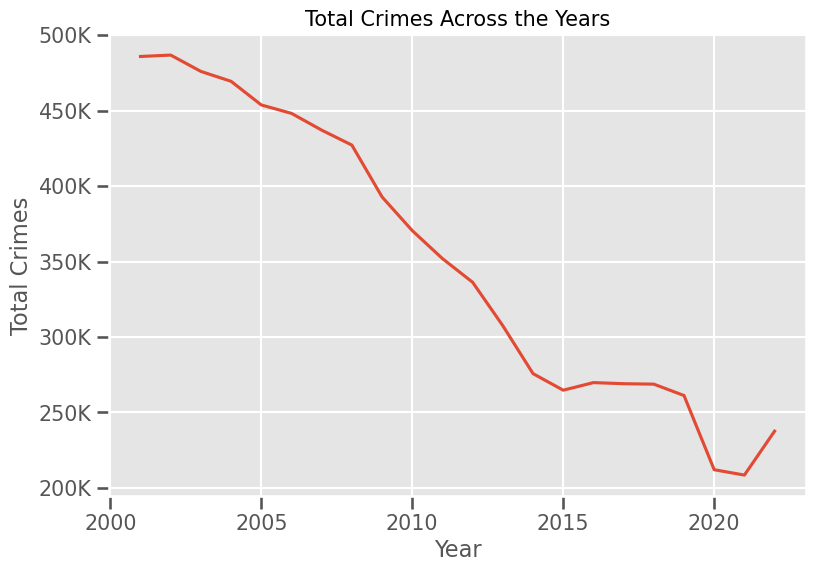

In [20]:
## Plotting the crimes across the years

## aggregating the total crimes per year
yearly_total_crime = yearly_crime_counts.groupby(by='Year').sum(numeric_only=True).reset_index()

## defining funcformatter function
def format_k(value, tick_number):
    if value >= 1000:
        return f'{int(value / 1_000)}K'
    else:
        return f'{float(value) / 1_000:.2f}K'

## defining plot function
def plot_line(data, x, y, title=None):
    g = sns.lineplot(data=data, x=x, y=y)
    g.set_title(title, fontsize=15)
    g.figure.set_size_inches(9, 6)
    g.yaxis.set_major_formatter(FuncFormatter(format_k))
    return g

g = plot_line(data=yearly_total_crime, x='Year', y='Total Crimes', title='Total Crimes Across the Years')
plt.gcf().savefig('img/total_crimes.png', dpi=300)


<strong>The above plot shows the total crimes across the years, and we can see that the total number of crimes is decreasing the years, but in 2022 is increasing the number.</strong>

#### Crime type per the years

In [21]:
def plot_facetgrid(data, col, x, y, marker=False, col_wrap=3, aspect=2, height=3, sharey=False, sharex=False, sup_title=None):
    g = sns.FacetGrid(data, col=col, col_wrap=col_wrap, sharey=sharey, sharex=sharex, aspect=aspect, height=height)
    g.map_dataframe(sns.lineplot, x=x, y=y, markers=marker, dashes=False, linewidth=2)
    g.set_axis_labels(x, y)
    g.set_titles('{col_name}')
    g.fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(sup_title, fontsize=25)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(format_k))
    return g

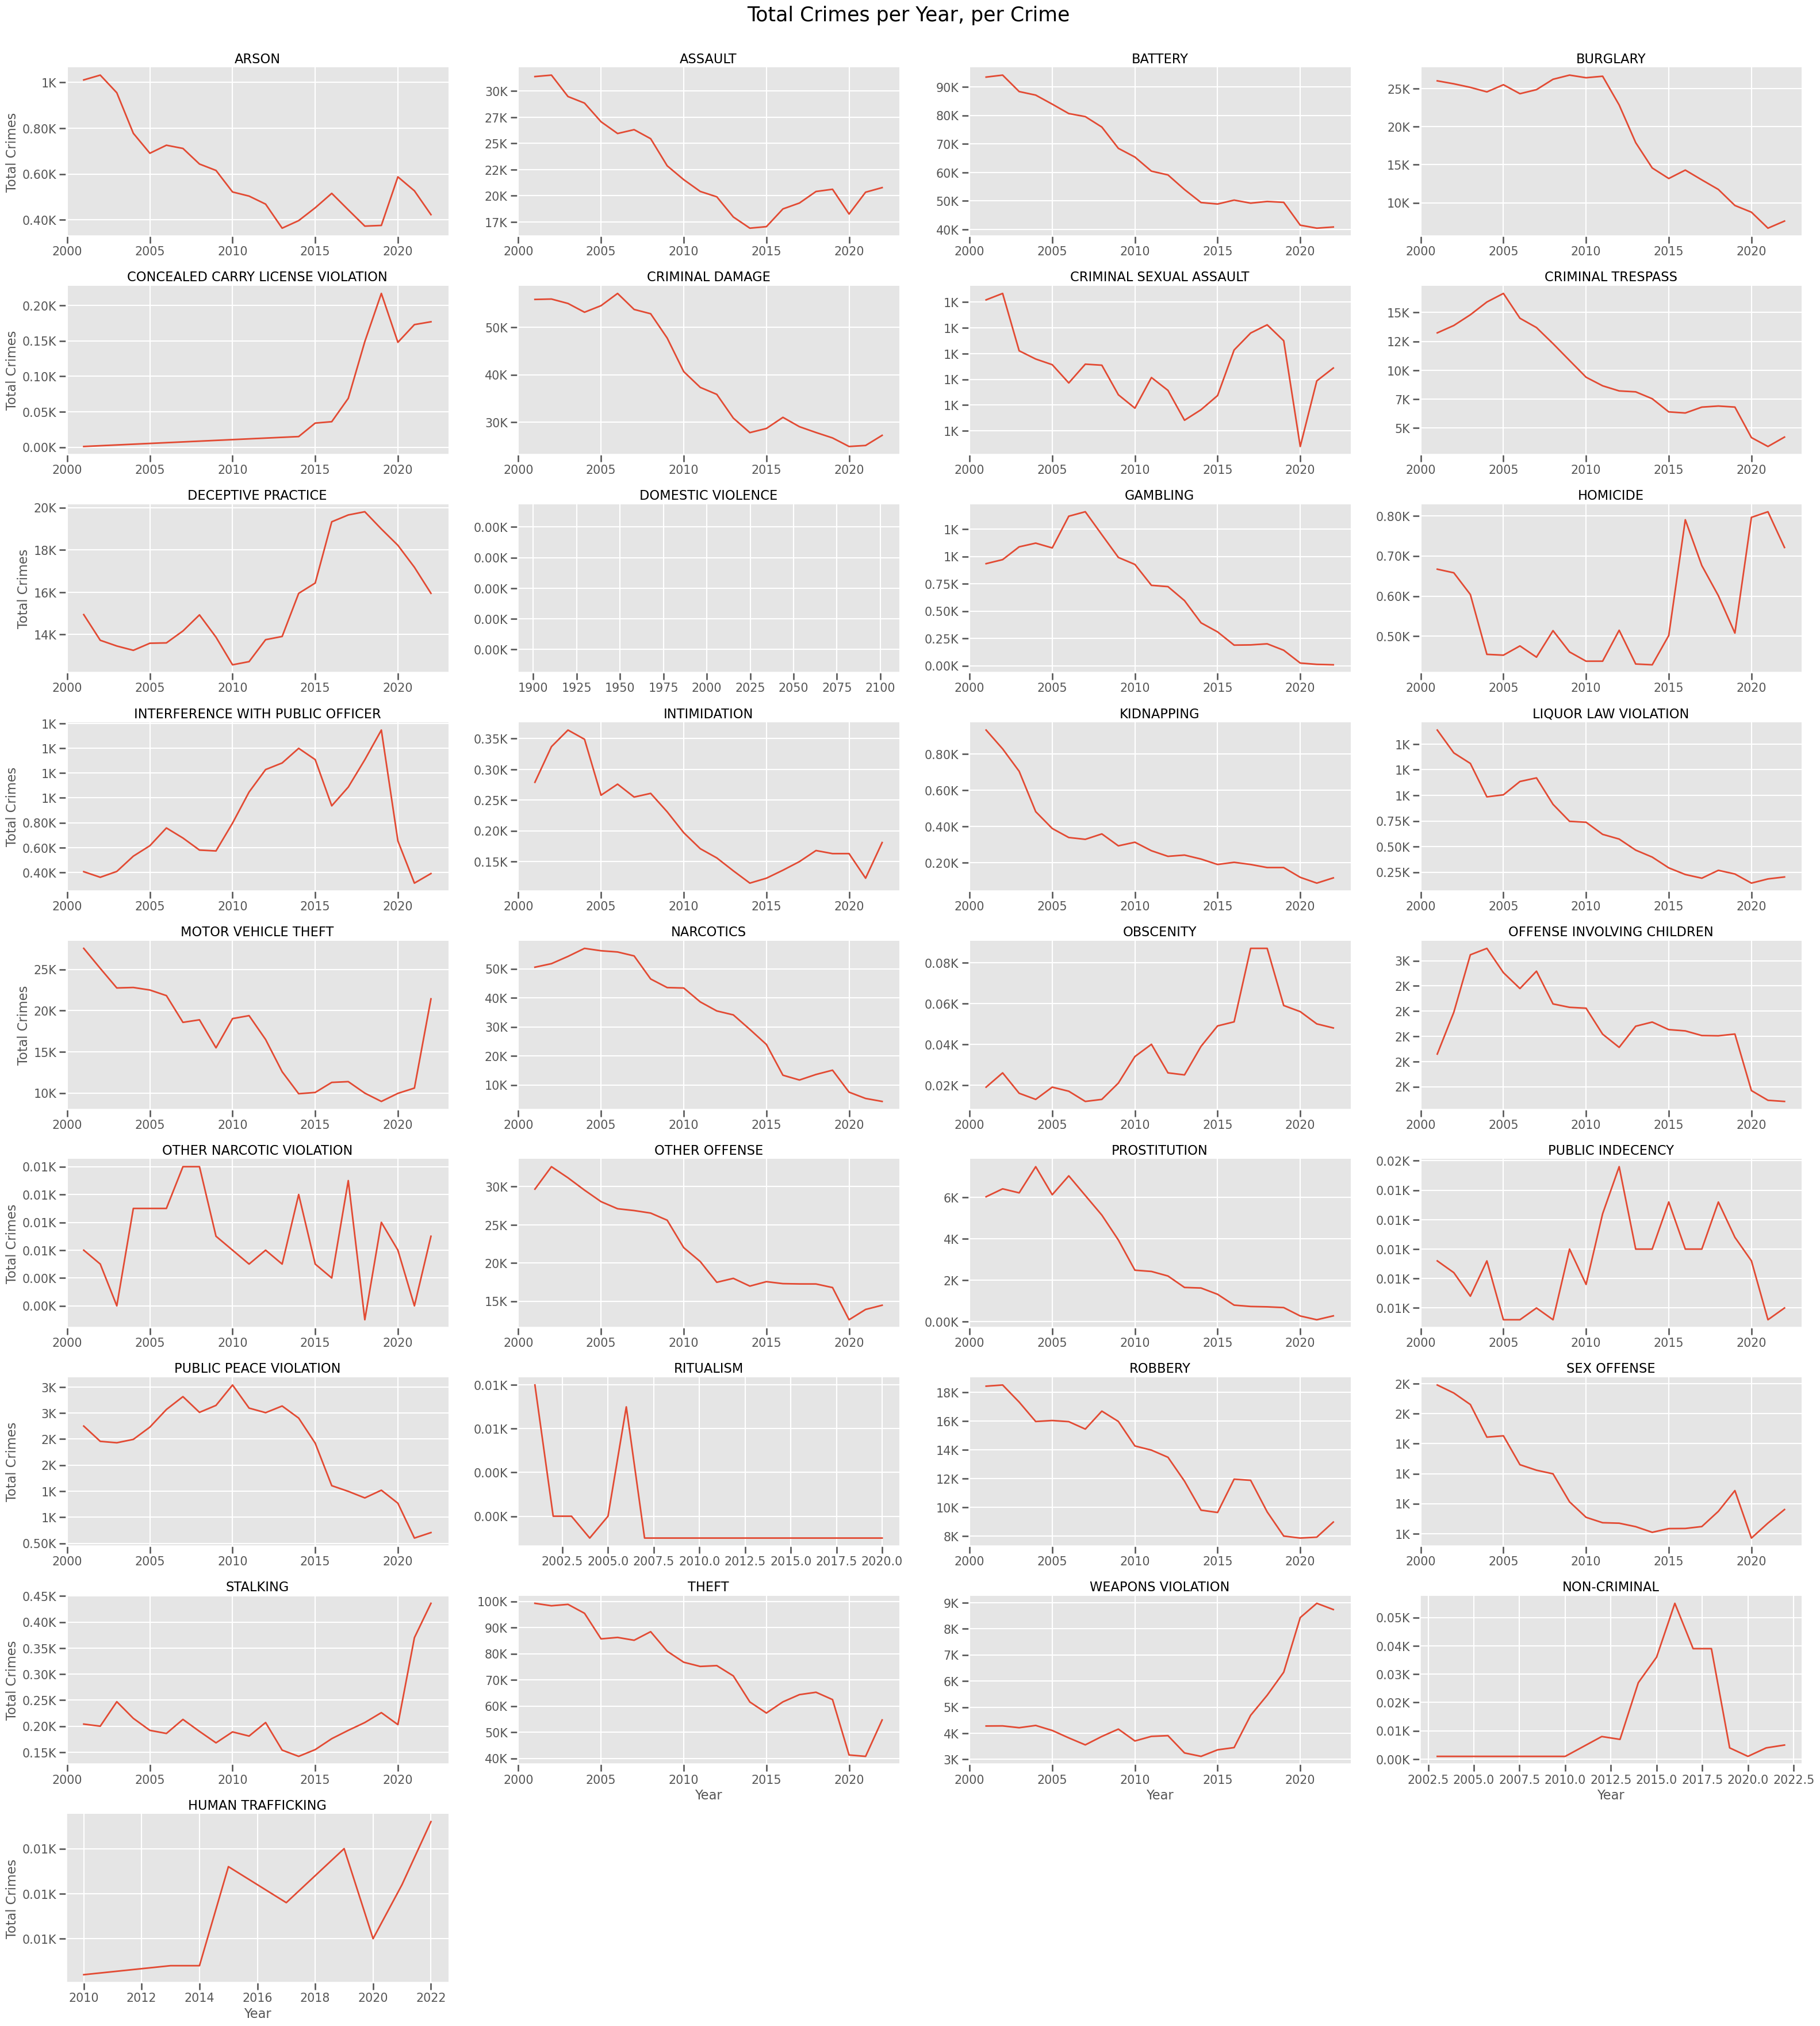

In [22]:
g = plot_facetgrid(data=yearly_crime_counts, col='Primary Type', x='Year', y='Total Crimes',
               sup_title='Total Crimes per Year, per Crime',  marker=True, col_wrap=4,
               aspect=2, height=4, sharex=False)
plt.gcf().savefig('img/crimes_per_year.png', dpi=300)

<strong>Despite the total number of crimes is decreasing, there are some crimes that are increasing the number of crimes, like: `CONCEALED CARRY LICENSE VIOLATION`, `CRIMINAL SEXUAL ASSAULT`, `DECEPTIVE PRACTICE`, `HOMICIDE`, `INTERFERENCE WITH PUBLIC OFFICER`, `OBSENITY`, `OTHER NARCOTIC VIOLATION`, `PUBLIC INDECENSY`, `WEAPONS VIOLATION`, `HUMAN TRAFFICKING`. Some of those have been maintaining waving behavior, some years going up and some years going down, but the overall trend is increasing. And others have been highly increasing in year 2020 and ahead, like `CRIMINAL SEXUAL ASSAULT`, `HOMICIDE`, `WEAPONS VIOLATION`, `HUMAN TRAFFICKING`.</strong>

### 3.3) Comparing AM vs. PM Rush Hour:

* Are crimes more common during AM rush hour or PM rush hour?
* What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
* Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?

Considering rush hours AM: 7 - 10 AM and 4 - 7 PM

In [23]:
## creating the hour column
data['Hour'] = data.index.hour
data.head()

ID                Primary Type  \
Date                                                       
2001-01-01 13:00:00  3769790                       THEFT   
2001-01-01 01:00:00  1310717             CRIMINAL DAMAGE   
2001-01-01 13:00:00  1358218                     ASSAULT   
2001-01-01 01:00:00  5462733  OFFENSE INVOLVING CHILDREN   
2001-01-01 01:00:00  1309918                       THEFT   

                                       Description Location Description  \
Date                                                                      
2001-01-01 13:00:00        AGG: FINANCIAL ID THEFT            RESIDENCE   
2001-01-01 01:00:00                     TO VEHICLE               STREET   
2001-01-01 13:00:00                         SIMPLE            APARTMENT   
2001-01-01 01:00:00  AGG CRIM SEX ABUSE FAM MEMBER            RESIDENCE   
2001-01-01 01:00:00                 $500 AND UNDER  TAVERN/LIQUOR STORE   

                     Arrest  Domestic  Beat  District  Ward   Latitude  \
Date                                                                     
2001-01-01 13:00:00   False     False   523       5.0  34.0  41.673171   
2001-01-01 01:00:00   False     False  2424      24.0   NaN  42.012391   
2001-01-01 13:00:00   False     False   312       3.0   NaN  41.778744   
2001-01-01 01:00:00   False      True   233       2.0  20.0  41.789084   
2001-01-01 01:00:00   False     False  1924      19.0   NaN  41.940001   

                     Longitude  Year  Hour  
Date                                        
2001-01-01 13:00:00 -87.638000  2001    13  
2001-01-01 01:00:00 -87.678032  2001     1  
2001-01-01 13:00:00 -87.612135  2001    13  
2001-01-01 01:00:00 -87.620849  2001     1  
2001-01-01 01:00:00 -87.654258  2001     1

In [24]:
## aggregating data by hour and crime type, and filtering data until 2022
hourly_crime_counts = data[data['Year'] <= 2022].groupby(by=['Hour','Primary Type']).size().to_frame('Total Crimes').reset_index()
hourly_crime_counts.sample(8, random_state = SEED)



Hour                Primary Type  Total Crimes
709    22  OFFENSE INVOLVING CHILDREN          1724
671    21                  KIDNAPPING           256
684    21                     ROBBERY         18338
103     3          DECEPTIVE PRACTICE          3292
371    12                       ARSON           302
325    10                   NARCOTICS         32975
340    11                     ASSAULT         26643
6       0     CRIMINAL SEXUAL ASSAULT          5076

I will aggregate by the mean of crimes per hour, and then I'll plot the results. Because whe data from several years.

In [25]:
## agregating data by hour
hourly_total_crimes = hourly_crime_counts.groupby(by='Hour').mean(numeric_only=True).reset_index()
hourly_total_crimes

Hour  Total Crimes
0      0  13724.531250
1      1   7887.516129
2      2   6441.593750
3      3   5556.566667
4      4   4219.066667
5      5   3517.500000
6      6   4109.700000
7      7   5678.774194
8      8   8416.935484
9      9  10753.354839
10    10  10541.516129
11    11  10685.468750
12    12  13828.500000
13    13  11443.093750
14    14  12152.562500
15    15  12815.062500
16    16  12154.500000
17    17  12367.156250
18    18  13171.187500
19    19  14021.096774
20    20  13973.580645
21    21  13138.875000
22    22  12929.718750
23    23  10747.843750

#### Plotting total crimes per hour

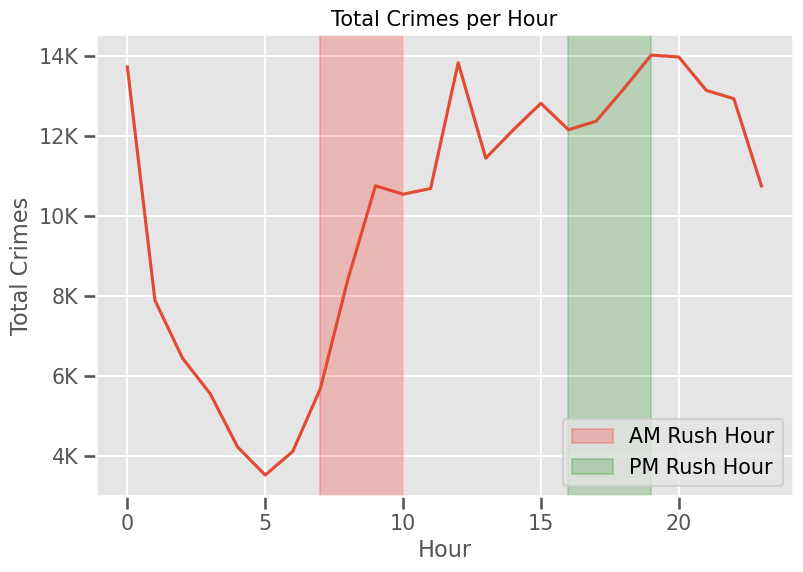

In [26]:
# plot total crimes per hour
g = plot_line(data=hourly_total_crimes, x='Hour', y='Total Crimes', title='Total Crimes per Hour')
g.axvspan(7, 10, color='red', alpha=0.2, label='AM Rush Hour')
g.axvspan(16, 19, color='green', alpha=0.2, label='PM Rush Hour')
g.legend()
plt.gcf().savefig('img/total_crimes_per_hour.png', dpi=300)

<strong>As we can see, the total number of crimes is higher (in average) during PM rush hour, and the total number of crimes is not lower during AM rush hour, but start increasing, in average.</strong>

#### Top 5 crimes on AM and PM rush hour

In [27]:
hourly_crime_counts

Hour                       Primary Type  Total Crimes
0       0                              ARSON          1064
1       0                            ASSAULT         17025
2       0                            BATTERY         71756
3       0                           BURGLARY         19584
4       0  CONCEALED CARRY LICENSE VIOLATION            49
..    ...                                ...           ...
748    23                            ROBBERY         16698
749    23                        SEX OFFENSE           976
750    23                           STALKING           157
751    23                              THEFT         52663
752    23                  WEAPONS VIOLATION          7934

[753 rows x 3 columns]

In [28]:
## filtering data by AM rush hour
am_rush_hour = hourly_crime_counts[(hourly_crime_counts['Hour'] >= 7) & (hourly_crime_counts['Hour'] <= 10)]
am_rush_hour

Hour                       Primary Type  Total Crimes
215     7                              ARSON           312
216     7                            ASSAULT          9882
217     7                            BATTERY         25524
218     7                           BURGLARY         21932
219     7  CONCEALED CARRY LICENSE VIOLATION            64
..    ...                                ...           ...
334    10                            ROBBERY          8242
335    10                        SEX OFFENSE          1151
336    10                           STALKING           228
337    10                              THEFT         75513
338    10                  WEAPONS VIOLATION          2909

[124 rows x 3 columns]

In [29]:
am_rush_hour_top5 = am_rush_hour.groupby(by='Primary Type')['Total Crimes'].sum(numeric_only=True).sort_values(ascending=False).head(5).reset_index()
am_rush_hour_top5['hour'] = 'AM Rush Hour'

In [30]:
pm_rush_hour = hourly_crime_counts[(hourly_crime_counts['Hour'] >= 16) & (hourly_crime_counts['Hour'] <= 19)]
pm_rush_hour

Hour                       Primary Type  Total Crimes
499    16                              ARSON           320
500    16                            ASSAULT         30544
501    16                            BATTERY         70307
502    16                           BURGLARY         19657
503    16  CONCEALED CARRY LICENSE VIOLATION            41
..    ...                                ...           ...
621    19                            ROBBERY         16698
622    19                        SEX OFFENSE          1322
623    19                           STALKING           186
624    19                              THEFT         85604
625    19                  WEAPONS VIOLATION          7513

[127 rows x 3 columns]

In [31]:
pm_rush_hour_top5 = pm_rush_hour.groupby(by='Primary Type')['Total Crimes'].sum(numeric_only=True).sort_values(ascending=False).head(5).reset_index()
pm_rush_hour_top5['hour'] = 'PM Rush Hour'

In [32]:
## merging both results
top5_crimes_am_pm = pd.concat([am_rush_hour_top5, pm_rush_hour_top5]).reset_index(drop=True)
top5_crimes_am_pm

Primary Type  Total Crimes          hour
0            THEFT        260731  AM Rush Hour
1          BATTERY        158471  AM Rush Hour
2  CRIMINAL DAMAGE        109084  AM Rush Hour
3         BURGLARY         96218  AM Rush Hour
4    OTHER OFFENSE         89831  AM Rush Hour
5            THEFT        379106  PM Rush Hour
6          BATTERY        287999  PM Rush Hour
7  CRIMINAL DAMAGE        183422  PM Rush Hour
8        NARCOTICS        164717  PM Rush Hour
9          ASSAULT        118177  PM Rush Hour

#### Plotting top 5 crimes on AM and PM rush hour

In [33]:
def plot_bars(data, x, y, col):
    g = sns.FacetGrid(data=data, col=col, col_wrap=2, sharey=True, sharex=False, aspect=1, height=6)
    g.map_dataframe(sns.barplot, y=y, x=x)
    g.set_axis_labels(x, y)
    g.set_titles('{col_name}')
    g.set_xticklabels(rotation=90)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(format_k))
    g.fig.tight_layout()
    return g

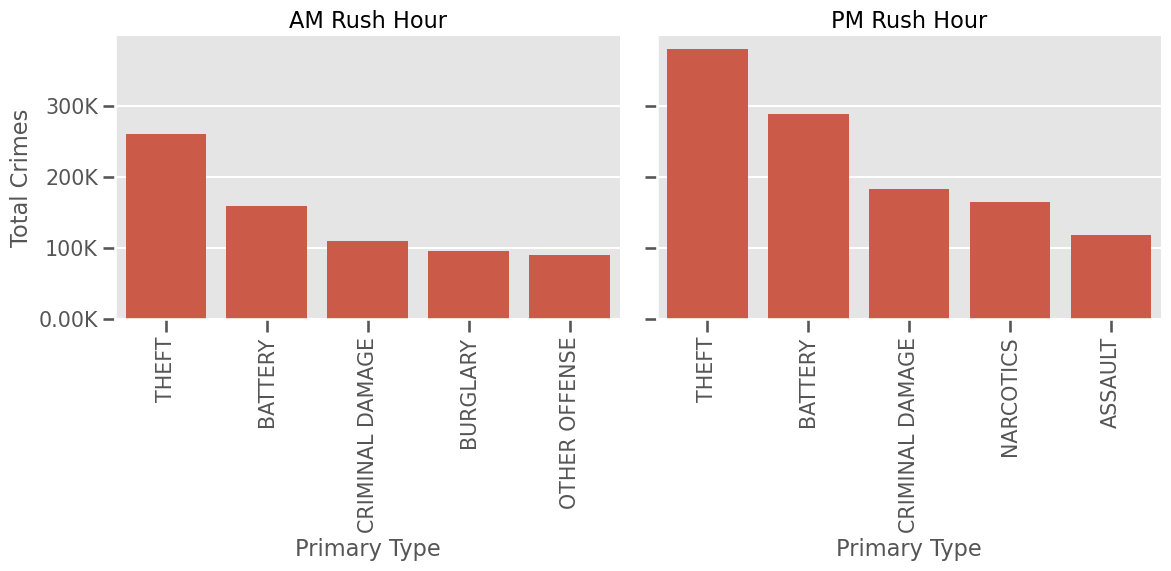

In [34]:
plot_bars(data=top5_crimes_am_pm, x='Primary Type', y='Total Crimes', col='hour')
plt.gcf().savefig('img/top5_crimes_am_pm.png', dpi=300)

<strong>As we can see, the top 5 crimes are mostly same on AM and PM rush hour, but the total number of crimes is higher (in average) on PM rush hour.</strong>

#### Motor Vehicle Thefts on AM and PM rush hour

In [35]:
hourly_crime_counts.groupby(by='Primary Type')['Total Crimes'].sum(numeric_only=True).sort_values(ascending=False).head(5).reset_index()

Primary Type  Total Crimes
0            THEFT       1626836
1          BATTERY       1410824
2  CRIMINAL DAMAGE        878896
3        NARCOTICS        745705
4          ASSAULT        501084

<strong>Also, we can see that `MOTOR VEHICLE THEFT` is not in the top 5 crimes on AM and PM rush hour. Not even int he whole dataset.</strong>